In [1]:
import pandas as pd
import string
import os
import itertools
import numpy as np
from sqlalchemy import create_engine, text

from app.backend.utils import DbEngine, Queries
from app.backend.etl import ETL
from app.backend.etl_sdhi import ETL_SDHI
from app.encoding_module.encoder import Encoding

In [22]:
import numpy as np
import sys

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import calinski_harabasz_score, fowlkes_mallows_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score, average_precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.decomposition import PCA
from kmodes.kmodes import KModes
from scipy.spatial import distance

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('seaborn')

In [3]:
pd.set_option("display.max_columns", 100)

### Connect to DB

In [4]:
db_engine = DbEngine(user = 'team77', 
                     password = 'mintic2020.',
                     ip = '172.17.0.3', 
                     port = '5432', 
                     db = 'minjusticia')
engine = db_engine.connect()
queries = Queries(engine)

### Loading original data

In [5]:
data = pd.read_excel('data/ReincidenciaPospenadosNal201011Junio2020Rev.xlsx', skiprows = 6)
data_shdi = pd.read_excel('data/SHDI Colombia 4.0.xlsx')

In [6]:
data2 = data[['INTERNOEN', 'DELITO', 'TITULO_DELITO', 'SUBTITULO_DELITO', 'TENTATIVA',
       'AGRAVADO', 'CALIFICADO', 'FECHA_INGRESO', 'FECHA_SALIDA',
       'FECHA_CAPTURA', 'SITUACION_JURIDICA', 'ANO_NACIMIENTO', 'EDAD',
       'GENERO', 'ESTADO_CIVIL', 'PAIS_INTERNO', 'DEPARTAMENTO', 'CIUDAD',
       'REINCIDENTE', 'ESTADO_INGRESO', 'ACTIVIDADES_TRABAJO',
       'ACTIVIDADES_ESTUDIO', 'ACTIVIDADES_ENSEÑANZA', 'NIVEL_EDUCATIVO',
       'HIJOS_MENORES', 'CONDIC_EXPECIONAL', 'CODIGO_ESTABLECIMIENTO',
       'ESTABLECIMIENTO', 'DEPTO_ESTABLECIMIENTO', 'MPIO_ESTABLECIMIENTO',
       'REGIONAL', 'ESTADO']]

### Execute ETL

In [ ]:
etl = ETL(queries)
etl.inmate_static_info(data2)
etl.inmate_variable_info(data2)

In [ ]:
etl_sdhi = ETL_SDHI(queries)
etl_sdhi.inmate_static_info(data_shdi)

### Functions

#### encodings

In [7]:
def encode_transform(data):
    encoders = []
    encoded_cols = []
    for i in range(data.values.shape[1]):
        le = LabelEncoder()
        le.fit(data.values[:,i])
        encoders.append(le)
        encoded_cols.append(le.transform(data.values[:,i]).reshape(-1,1))
    return np.concatenate(encoded_cols, axis = 1), encoders

#### metrics-results

In [8]:
def plot_confusion_matrix(labels, prediction, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.get_cmap('Blues')):
    """ Dibuja la matriz de confusion de los resultados de clasificacion de un modelo.
    Se puede aplicar normalizacion ajustando 'normalize=True'. """

    n = len(classes)
    if len(prediction.shape) != 1:
        matrix = multilabel_confusion_matrix(labels, prediction).reshape(n,4)
    else:
        matrix = confusion_matrix(labels, prediction)

    size = 1.4 * len(classes)
    plt.figure(figsize=(size, size))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))

    if len(prediction.shape) != 1:
        plt.xticks(tick_marks, ['True Negatives', 'False Negatives', 'False Positives', 'True Positives'], rotation=90)
    else:
        plt.xticks(tick_marks, classes, rotation=90)

    plt.yticks(tick_marks, classes)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j],
                 horizontalalignment='center',
                 color='white' if matrix[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def classifier_results(prediction, labels, classes, show_plots):
    """ Muestra los resultados de accuracy, presenta los resultados de precision, recall y f1-score
    y genera la matriz de confusion para el conjunto de datos."""

    print('\nAccuracy:\n{0:.2f}'.format(accuracy_score(labels, prediction)))

    print(classification_report(labels, prediction, digits=2, target_names = classes))
    
    if show_plots:
        plot_confusion_matrix(labels, prediction, classes)

    return classification_report(labels, prediction, digits=2, output_dict=True)

def plot_roc(y_test, y_preds):
    """
    Helper function that plots the roc curve
    """
    plt.figure(figsize=(8,8))
    for label in np.unique(y_test):
        fpr, tpr, _ = roc_curve(y_test == label, y_preds == label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label= str(label) + ' AUC = ' + '{0:.2f}'.format(roc_auc))
        #plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic ROC')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall(y_test, y_preds):
    #plt.figure(figsize=(8,8))
    #for idx, label in enumerate(classes):
    #    roc_auc = auc(x[idx], y[idx])
    #    plt.plot(x[idx], y[idx], linewidth=2, label=str(label) + ': ' + 'AUC = ' + '{0:.2f}'.format(roc_auc) + ' - ' +
    #                                                               'AP = ' + '{0:.2f}'.format(ap[idx]) + ' - ' +
    #                                                               'F1 = ' + '{0:.2f}'.format(f1[idx]))
    #plt.xlim([0.0, 1.05])
    #plt.ylim([0.0, 1.05])
    #plt.xlabel('Recall')
    #plt.ylabel('Precision')
    #plt.title('Precision Recall Curve')
    #plt.legend(loc="lower right")
    #plt.grid()
    #plt.show()
    """
    Helper function that plots the roc precision recall Curve
    """
    plt.figure(figsize=(8,8))
    for label in np.unique(y_test):
        fpr, tpr, _ = precision_recall_curve(y_test == label, y_preds == label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label= str(label) + ' AUC = ' + '{0:.2f}'.format(roc_auc))
        #plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

#### algorithms

In [9]:
##### Get closest centroid unoptimized (Prediction Strength)
def get_closest_centroid(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    min_distance = sys.float_info.max
    min_centroid = 0
    
    for c in centroids:
        dist = distance.euclidean(obs, c)
        if dist < min_distance:
            min_distance = dist
            min_centroid = c
            
    return min_centroid

##### Get closest centroid optimized v1 (Prediction Strength)
def get_closest_centroid_optim(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    
    distance = np.sqrt((np.square(centroids[:,np.newaxis]-obs).sum(axis=2)))
    idx_min_distance = np.argmin(distance)
    
    return centroids[idx_min_distance]

##### Get closest centroid optimized v2 (Prediction Strength)
def get_closest_centroid_optim_vectorized(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    
    distance = np.sqrt((np.square(centroids[:,np.newaxis]-obs).sum(axis=2)))
    idx_min_distance = np.argmin(distance, axis = 0)
    
    return centroids[idx_min_distance]

##### Get prediction strength unoptimized (Prediction Strength)
def get_prediction_strength(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    n_test = len(x_test)
    
    # populate the co-membership matrix
    D = np.zeros(shape=(n_test, n_test))
    for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
        for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
            if tuple(x1) != tuple(x2):
                if tuple(get_closest_centroid(x1, train_centroids)) == tuple(get_closest_centroid(x2, train_centroids)):
                    D[c1,c2] = 1.0
    
    # calculate the prediction strengths for each cluster
    ss = []
    for j in range(k):
        s = 0
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
            for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
                if tuple(x1) != tuple(x2) and l1 == l2 and l1 == j:
                    s += D[c1,c2]
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

##### Get prediction strength optimized (Prediction Strength)
def get_prediction_strength_optim(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    closest_cent = get_closest_centroid_optim_vectorized(x_test, train_centroids)
    
    co_membership = np.zeros((len(closest_cent), len(closest_cent)))
    for i in range(1, len(closest_cent)):
        diag = (closest_cent == np.roll(closest_cent, shift = i, axis = 0)).all(1)[i:]
        co_membership[range(i,len(closest_cent)),range(len(diag))] = diag
    co_membership = co_membership + co_membership.T - np.diag(np.diag(co_membership))
    
    # calculate the prediction strengths for each cluster
    n_test = len(x_test)
    ss = []
    for j in range(k):
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        test_labels_co_mem = np.zeros((len(test_labels), len(test_labels)))
        for i in range(len(test_labels)):
            diag = (test_labels == np.roll(test_labels, shift = i)) & (test_labels == j)
            diag = diag[i:]
            test_labels_co_mem[range(i,len(test_labels)),range(len(diag))] = diag
        test_labels_co_mem = test_labels_co_mem + test_labels_co_mem.T - np.diag(np.diag(test_labels_co_mem))
        s = (co_membership * test_labels_co_mem).sum()
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

### Encode

In [10]:
encoding = Encoding(queries)

In [12]:
inmate_sup = encoding.get_data('recidivism')

In [13]:
data_encoded = encoding.supervised(inmate_sup)

/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [18]:
data_encoded.shape

(103216, 237)

In [15]:
data_encoded.columns

Index(['INTERNOEN', 'FECHA_INGRESO', 'FECHA_SALIDA', 'ANIO_NACIMIENTO',
       'GENERO', 'HIJOS_MENORES', 'ACTIVIDADES_TRABAJO', 'ACTIVIDADES_ESTUDIO',
       'ACTIVIDADES_ENSEÑANZA', 'MADRE_GESTANTE',
       ...
       'REGIONALNME_CENTRAL', 'REGIONALNME_NOROESTE', 'REGIONALNME_NORTE',
       'REGIONALNME_OCCIDENTE', 'REGIONALNME_ORIENTE',
       'REGIONALNME_VIEJO CALDAS', 'timejail_day', 'FECHA_SALIDA_t_1',
       'recidivism_day', 'year'],
      dtype='object', length=237)

#### Evaluating remaining Nans

Im gonna delete the out dates

In [17]:
data_encoded.isnull().sum().to_frame().rename(columns={0:'counts'}).sort_values(by='counts', ascending = False)

,counts
FECHA_SALIDA_t_1,78809
FECHA_SALIDA,30291
INTERNOEN,0
JAILNAME_EPMSC LA PLATA,0
JAILNAME_EPMSC FACATATIVA,0
...,...
JAILNAME_COMPLEJO IBAGUE - PICALEÑA,0
JAILNAME_CPAMS LA PAZ,0
JAILNAME_CPAMS PALMIRA,0
JAILNAME_CPMS BUCARAMANGA (ERE),0


In [21]:
data_encoded = data_encoded[data_encoded.columns[~data_encoded.columns \
                                                 .isin(['FECHA_SALIDA_t_1','FECHA_SALIDA'])]]
data_encoded.shape

(103216, 235)

#### Deleting not importante features for the analysis

In [30]:
identity = data_encoded[['INTERNOEN','FECHA_INGRESO']]

In [31]:
data_encoded = data_encoded[data_encoded.columns[~data_encoded.columns \
                                                 .isin(['INTERNOEN',
                                                        'FECHA_INGRESO',
                                                        'FECHA_CAPTURA'])]]
data_encoded.shape

(103216, 233)

### Dimentionality Reduction

Im doing the dimentionality reduction becasue we have a mix of categorical and continuous data, which wont work well with any clustering method. Doing this, im transforming the data into a new vector space with a continuous represenation per each orthogonal feature. This wont allow us to interpret as well the cluster as before, that is why i saved the idenity df before.

In [32]:
pca = PCA(n_components = 'mle', svd_solver = 'full')
pca.fit(data_encoded.values)

PCA(n_components='mle', svd_solver='full')

In [33]:
data_reduced = pca.transform(data_encoded.values)
data_reduced.shape

(103216, 223)

### Unsupervised Learning with GMM

#### Elbow Plot (Within sum of squares distance)

In [38]:
# setting the range of k
clusters = range(1, 20)

In [39]:
# running the clustering 
wss_list = []
for k in clusters:
    #gmm = GaussianMixture(n_components=k, covariance_type = 'diag', random_state=42)
    gmm = BayesianGaussianMixture(n_components=k, covariance_type = 'diag', random_state=42)
    gmm.fit(data_reduced)
    c_labels = gmm.predict(data_reduced)
    wss = 0
    for k in np.unique(c_labels):
        c_idx = c_labels == k
        d_ck = data_reduced[c_idx]
        center = gmm.means_[k]
        wss += ((d_ck - center)**2).sum(1).sum()
    wss_list.append(wss)

/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


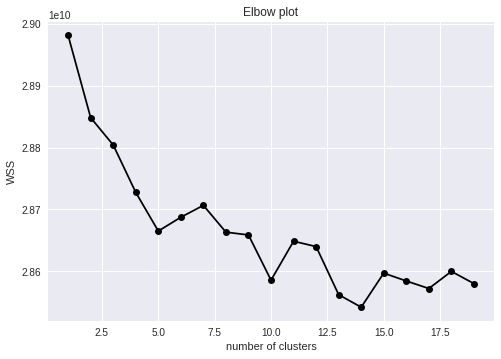

In [40]:
# plotting bgmm
_, ax = plt.subplots()
ax.plot(clusters, wss_list, '-o', color='black')
ax.set(title='Elbow plot', 
       xlabel='number of clusters', 
       ylabel='WSS');

#### Calinski Harabaz Score

In [43]:
# setting the range of k
clusters = range(2, 20)
k_calinski_harabasz = []
for k in clusters:
    #model = GaussianMixture(n_components=k, covariance_type = 'diag', random_state=42)
    model = BayesianGaussianMixture(n_components=k, covariance_type = 'diag', random_state=42)
    model.fit(data_reduced)
    
    cluster = model.predict(data_reduced)
    score   = calinski_harabasz_score(data_reduced, cluster)
    
    k_calinski_harabasz.append(round(score,2))

/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


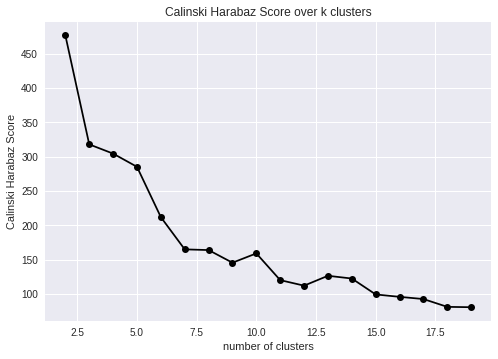

In [44]:
# plotting bgmm
_, ax = plt.subplots()
ax.plot(clusters, k_calinski_harabasz, '-o', color='black')
ax.set(title='Calinski Harabaz Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Calinski Harabaz Score');